In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import matplotlib.pyplot as plt

from models.model import get_model
from scripts.attribution_methods import generate_attributions
from scripts.normalize import normalize
import scripts.datasets as datasets
from scripts.ensemble import generate_ensembles

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(device)

cuda:0


## Parameters

In [4]:
params = {
    "model": "mnist_model",
    "dataset": "mnist",
    "batch_size": 5,
    "max_nr_batches": 2,  # -1 for no early stopping
    "attribution_methods": [
        "gradientshap",
        "deeplift",
        "lime",
        "saliency",
        "smoothgrad",
        "integrated_gradients",
        "guidedbackprop",
        "gray_image",
    ],
    "ensemble_methods": [
        "mean",
        "variance",
        "rbm",
        "flipped_rbm",
        "rbm_flip_detection",
    ],
    "attribution_processing": "filtering",
    "normalization": "min_max",
    "scoring_methods": ["insert", "delete", "irof"],
    "scores_batch_size": 40,
    "package_size": 1,
    "irof_segments": 60,
    "irof_sigma": 4,
    "batches_to_plot": [0],
}


In [5]:
attribution_params = {
    "lime": {
        "use_slic": True,
        "n_slic_segments": 100,
    },
    "integrated_gradients": {
        "baseline": "black",
    },
    "noise_normal": {},
    "deeplift": {},
    "gradientshap": {},
    "saliency": {},
    "occlusion": {},
    "smoothgrad": {},
    "guidedbackprop": {},
    "gray_image": {},
}

In [6]:
rbm_params = {
    "batch_size": 15,
    "learning_rate": 0.001,
    "n_iter": 300,
}

## Helper functions

In [7]:
def plot(raw_images, attributions, ensemble_attributions):
    for idx in range(attributions.shape[1]):
        # idx = 0  # first image of the batch
        orig_image = raw_images[idx].detach().cpu().numpy()
        orig_image = orig_image.transpose(1, 2, 0)
        # For MNIST remove the color dimension
        if orig_image.shape[2] == 1:
            orig_image = orig_image.reshape(orig_image.shape[0:2])
        images = [orig_image]


        # one image for every attribution method
        for j, title in enumerate(params["attribution_methods"]):
            # Remove randoms step 1
            if "noise" in title:
                continue
            attribution_img = attributions[j][idx].cpu().detach().numpy()
            images.append(attribution_img)
            #     # one image for every ensemble method
        for j in range(len(params["ensemble_methods"])):
            ensemble_img = ensemble_attributions[j][idx].cpu().detach().numpy()
            images.append(ensemble_img)

        # Remove the randoms step 2
        non_random = np.array(["noise" not in t for t in params["attribution_methods"]])
        attr_methods = np.array(params["attribution_methods"])[non_random]

        my_plot(
            images,
            ["original"]
            + list(attr_methods)
            + params["ensemble_methods"]
            + ["flipped_rbm"]
        )


In [8]:
def my_plot(images, titles):
    # make a square
    x = int(np.ceil(np.sqrt(len(images))))
    fig, axs = plt.subplots(x, x, figsize=(15, 15))

    # Remove the NaNs
    for i in range(len(images)):
        images[i][np.isnan(images[i])] = 0

    # Ensure that all attributions get equal weight during plotting
    mean_max_value = np.mean([np.max(img / np.sum(img)) for img in images[1:]])

    # plot the images
    for i, ax in enumerate(axs.flatten()):
        if i < len(images):
            if i == 0:
                # Show the original image
                ax.imshow(images[i])
            else:
                # Plot the attributions and ensure equal plotting
                img = images[i] / np.sum(images[i]) / mean_max_value
                ax.imshow(img, vmin=0, vmax=1 / 3, cmap="Greens")
            ax.set_axis_off()
            ax.set_title(titles[i], color="blue", fontdict={"fontsize": 20})
        else:
            ax.set_visible(False)

    plt.tight_layout()
    plt.show()

## running the code

In [9]:
# classification model
model = get_model(params["model"], device=device)

models loaded


In [10]:
# dataset and which images to explain the classification for
dataset = datasets.get_dataset(params["dataset"])
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False, num_workers=2
)

dataset_raw = datasets.get_dataset(params["dataset"], normalized=False)
dataloader_raw = torch.utils.data.DataLoader(
    dataset_raw, batch_size=1, shuffle=False, num_workers=2
)

img, label = next(iter(dataloader))
img = img.to(device)
label = label.to(device)

raw_img = next(iter(dataloader_raw))[0]

In [11]:
###########################
#      attributions       #
###########################
attributions = generate_attributions(
    img,
    label,
    model,
    params,
    attribution_params,
    device,
)

zero = torch.Tensor([0]).to(device)
# Set negative values to zero
attributions = torch.max(attributions, zero)
# Make sure we have values in range [0,1]
attributions = normalize(params["normalization"], arr=attributions)

In [12]:
###########################
#        ensembles        #
###########################

ensemble_attributions = generate_ensembles(
    attributions, params["ensemble_methods"], rbm_params, device
)

# make sure it sums to 1
ensemble_attributions = normalize(
    params["normalization"], arr=ensemble_attributions
)

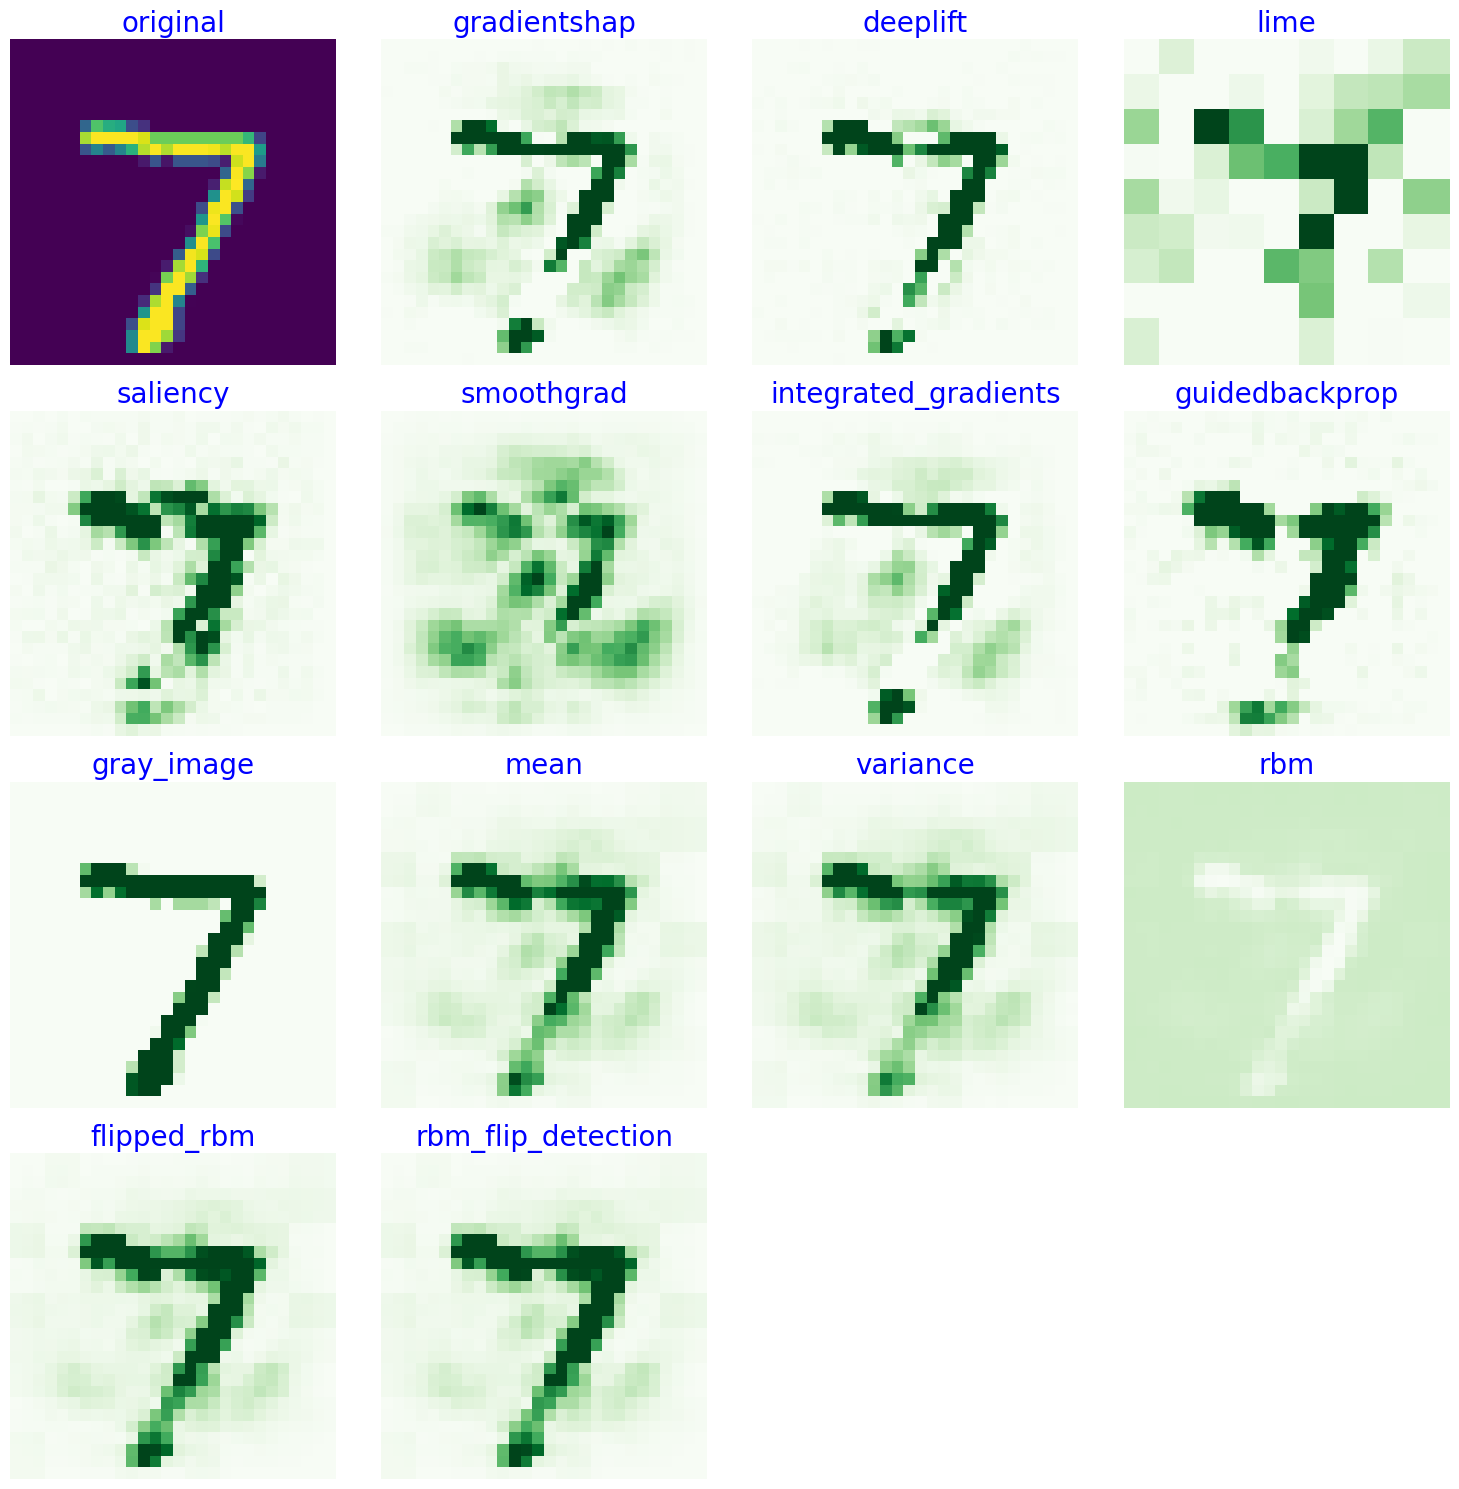

In [13]:
plot(raw_img,
     attributions,
     ensemble_attributions
)